In [ ]:
!pip install validators
!pip install torch torchvision torchaudio
!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
%pip install torchinfo

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd
import gc
import traceback
import random
from IPython.display import HTML
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score   
import sklearn.metrics as sm

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [49]:
# Number of workers for dataloader
workers = 8

# Batch size during training
BATCH_SIZE  = 64
batch_size =64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
IMAGE_SIZE = 64

# Number of training epochs
NUM_EPOCHS = 3

# Learning rate for optimizers
lr = 0.1

# Beta1 hyperparam for optimizers
beta1 = 0.9

# Beta2 hyperparam for optimizers
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [4]:
#DATADIR = "BeeMachine_quarter"
DATADIR = "C:/Users/drago/Documents/2022 CIS 732/Project/Cropped_Bombus/Bumble_iNat_BugGuide_BBW_BBB"

CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

Import Data

In [5]:
# def load_dataset(is_simple_transform=True):
#     if is_simple_transform:
#         transformer = transforms.Compose([
#             transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
#             transforms.ToTensor(),
#              transforms.Normalize([0.5],[0.5])
#         ])
#     else:
#         transformer = transforms.Compose([
#             transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
#             transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.4904, 0.4515, 0.3639],
#                                     std=[0.2403, 0.2280, 0.2248])
#         ])
#     #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     #Load image
#     dataset = datasets.ImageFolder(root=f'{DATADIR}', transform=transformer)
#     return dataset

In [6]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [7]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        #transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4904, 0.4515, 0.3639],
                                    std=[0.2403, 0.2280, 0.2248])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]),
}


def load_dataset(transformer):        
    #Load image
    dataset = datasets.ImageFolder(root=f'{DATADIR}', transform=transformer)
    return dataset

In [8]:
# def find_mean_std(dataset):
#     loader = torch.utils.data.DataLoader(dataset, batch_size=8)
#     nimages = 0
#     mean = 0.
#     std = 0.
#     for batch, _ in loader:
#         # Rearrange batch to be the shape of [B, C, W * H]
#         batch = batch.view(batch.size(0), batch.size(1), -1)
#         # Update total number of images
#         nimages += batch.size(0)
#         # Compute mean and std here
#         mean += batch.mean(2).sum(0) 
#         std += batch.std(2).sum(0)

#     # Final step
#     mean /= nimages
#     std /= nimages

#     print(mean)
#     print(std)

# #find_mean_std(bee_dataset)
# # mean tensor([0.4904, 0.4515, 0.3639])
# # std tensor([0.2403, 0.2280, 0.2248])

In [9]:
#bee_dataset = load_dataset(is_simple_transform=True)
bee_dataset = load_dataset(data_transforms['train'])

num_classes=len(bee_dataset.targets)
train_indices, val_indices = train_test_split(list(range(num_classes)), test_size=0.2, stratify=bee_dataset.targets)
train_dataset = torch.utils.data.Subset(bee_dataset, train_indices)
val_dataset = torch.utils.data.Subset(bee_dataset, val_indices)
resnet50.fc = nn.Sequential(
               nn.Linear(2048, IMAGE_SIZE),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(IMAGE_SIZE, 45),
               nn.Softmax()).to(device) 
torch.autograd.set_detect_anomaly(True)      

Create DataLoader

In [10]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
print(len(train_dataset))
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=workers)
print(len(val_dataset))
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)

31848
7962


In [11]:
# train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
# print(torch.cuda.memory_allocated(device))
# val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
# print(torch.cuda.memory_allocated(device))
# print (len(val_dataset))
# print (len(train_dataset))


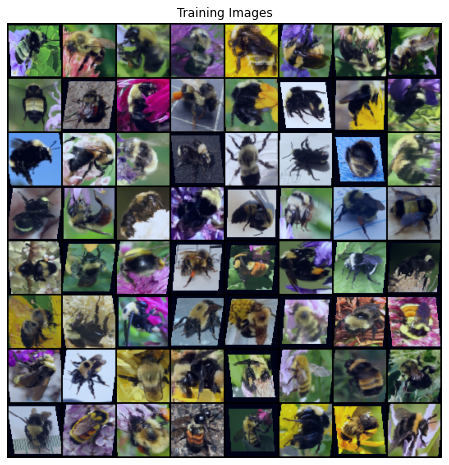

In [12]:
# Plot some training images
real_batch = next(iter(train_data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
weights = class_weight.compute_class_weight('balanced', np.unique(bee_dataset.targets), bee_dataset.targets)
#class_weights=torch.tensor(np.unique(bee_dataset.targets),dtype=torch.float).to(device)
class_weights=torch.tensor(weights,dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=beta1)

In [ ]:
# valid_loss_min = np.Inf
# val_loss = []
# val_acc = []
# train_loss = []
# train_acc = []
# total_step = len(train_dataset)

# def train_model(model, dataloaders, criterion, optimizer, train_loss, train_acc, total_step, num_epochs=3):
#     for epoch in range(1, num_epochs+1):
#         running_loss = 0.0
#         correct = 0
#         total=0
#         model.train()
#         print(f'Epoch {epoch}\n')
#         for batch_idx, (data_, target_) in enumerate(dataloaders):
#             data_, target_ = data_.to(device), target_.to(device)            
#             outputs = model(data_)
#             loss = criterion(outputs, target_)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _,pred = torch.max(outputs, dim=1)
#             correct += torch.sum(pred==target_).item()
#             total += target_.size(0)
#             #print("matrix predict {} target {}".format(pred, target_))
#             if (batch_idx) % 20 == 0:
#                 print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                     .format(epoch, num_epochs, batch_idx * batch_size, total_step, loss.item()))
#         train_acc.append(100 * correct / total)
#         train_loss.append(running_loss/total_step)
#         print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        
#         validate_model(model, val_data_loader, valid_loss_min, val_loss, val_acc)
                  
#     return model

In [ ]:
# def validate_model(model, dataloaders, valid_loss_min, val_loss, val_acc):
#     batch_loss = 0
#     total_t=0
#     correct_t=0
#     with torch.no_grad():
#         model.eval()
#         for data_, target_ in dataloaders:
#             data_t, target_t = data_.to(device), target_.to(device)
#             outputs_t = model(data_t)
#             loss_t = criterion(outputs_t, target_t)
#             batch_loss += loss_t.item()
#             _,pred_t = torch.max(outputs_t, dim=1)
#             #print("predict {} target {}".format(len(pred_t), len(target_t)))
#             #print("matrix predict {} target {}".format(pred_t, target_t))
#             correct_t += torch.sum(pred_t==target_t).item()
#             total_t += target_t.size(0)
#         val_acc.append(100 * correct_t/total_t)
#         val_loss.append(batch_loss/len(dataloaders))
#         network_learned = batch_loss < valid_loss_min
#         print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
#         if network_learned:
#             modelPath = 'models/pytorch'
#             isExist = os.path.exists(modelPath)
#             if not isExist:
#                 # Create a new directory because it does not exist 
#                 os.makedirs(modelPath)
#                 print("The new directory {} is created!".format(modelPath))
#             valid_loss_min = batch_loss
#             torch.save(model.state_dict(), 'models/pytorch/traiend_resnet50.h5')
#             print('Improvement-Detected, save-model')

In [14]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    
actuals, probabilities = [], []
def process(model, train_loader, test_loader, epochs, lr):
    
    model = torch.nn.DataParallel(model).cuda()

    # define loss function (criterion) and optimizer
    class_weights=torch.tensor(np.unique(bee_dataset.targets),dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(class_weights).cuda()
    optimizer_new = torch.optim.SGD(model.parameters(), lr,
                                momentum=beta1, 
                                weight_decay=1e-4)

    # train & test process
    def train(train_loader, current_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total=0
        targets, preds = [], []
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _,pred = torch.max(output, dim=1)
            correct += torch.sum(pred==target).item()
            total += target.size(0)
            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

            #print('\rTraining %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)
            if (batch_idx) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} \n' 
                    .format(current_epoch, num_epochs, batch_idx, len(train_loader), loss.item()))
            train_acc.append(100 * correct / total)
            train_loss.append(running_loss/total_step)
            
        printMatries(targets, preds)            
       

    def test(test_loader):
        model.eval()
        correct = 0
        total = 0
        batch_loss = 0
        targets, preds = [], []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _,pred = torch.max(output, dim=1)
                actuals.extend(target.view_as(pred).cpu() == 45)
                probabilities.extend(np.exp(output.cpu()[:, 44]))
                correct += torch.sum(pred==target).item()
                
                total += target.size(0)
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())
                
                
        test_acc = 100. * correct / total
        val_acc.append(test_acc)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        displayROC_Curve(actuals, probabilities)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch} \n")
        adjust_learning_rate(optimizer_new, epoch, lr)
        train(train_loader, epoch, epochs)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\nBest test acc = %2.4f%%' % max(test_accs), flush=True)
    labels = [label for _, label in train_data_loader.dataset]
    classe_labels, counts = np.unique(labels, return_counts=True)    
    vis(test_accs, confusion_mtxes, classe_labels)

In [15]:
def printMatries(labels, preds):
     print('F1: {:.4f}'.format(f1_score(labels, preds, average='weighted')))
     print('Precision: {:.4f}'.format(precision_score(labels, preds, average='weighted')))
     print('Recall: {:.4f}'.format(recall_score(labels, preds, average='weighted')))
     print('Accuracy: {:.4f}'.format(accuracy_score(labels, preds)))

In [16]:
def displayROC_Curve(actuals, probabilities):
    fpr, tpr, _ = sm.roc_curve(actuals, probabilities)
    roc_auc = sm.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for digit=%d class' % 45)
    plt.legend(loc="lower right")
    plt.show()

In [17]:
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [19]:
def show_confusion_matrix(model, labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

Dataset: 31848 training samples & 7962 testing samples

Distribution of classes in dataset:


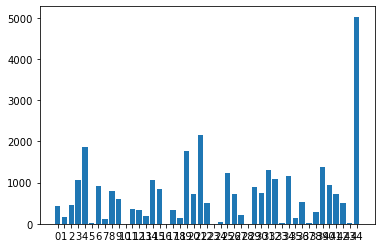

<Figure size 1440x720 with 0 Axes>

In [18]:
print('Dataset: %d training samples & %d testing samples\n' % (
    len(train_data_loader.dataset), len(val_data_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
fig = plt.figure(figsize=(20,10))
labels = [label for _, label in train_dataset]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

In [ ]:
try:
    process(resnet50, train_data_loader, val_data_loader, NUM_EPOCHS, lr)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Epoch 1 

Epoch [1/3], Step [0/156], Loss: 3.8064 

Epoch [1/3], Step [100/156], Loss: 3.8074 

F1: 0.0115
Precision: 0.0171
Recall: 0.0208
Accuracy: 0.0208


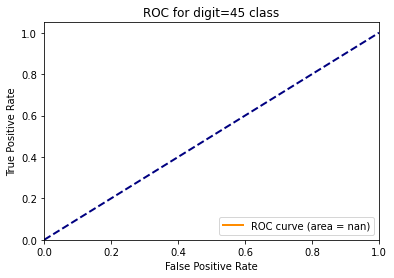


Best test acc = 1.5700%
Epoch 2 

Epoch [2/3], Step [0/156], Loss: 3.8069 

Epoch [2/3], Step [100/156], Loss: 3.8059 

F1: 0.0113
Precision: 0.0243
Recall: 0.0214
Accuracy: 0.0214


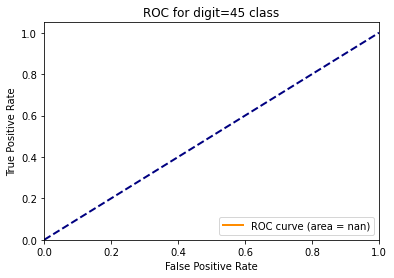


Best test acc = 1.5700%
Epoch 3 

Epoch [3/3], Step [0/156], Loss: 3.8067 

Epoch [3/3], Step [100/156], Loss: 3.8067 

F1: 0.0108
Precision: 0.0406
Recall: 0.0205
Accuracy: 0.0205


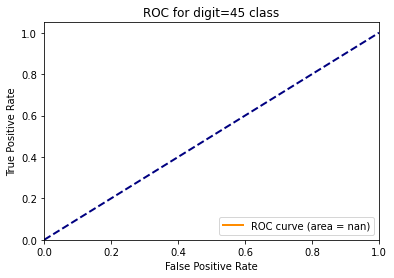


Best test acc = 1.6202%
Traceback (most recent call last):
  File "<ipython-input-35-3542a4716402>", line 2, in <module>
    process(resnet50, train_data_loader, val_data_loader, NUM_EPOCHS, lr)
  File "<ipython-input-14-474f3b8a69c0>", line 91, in process
    vis(test_accs, confusion_mtxes, classe_labels)
  File "<ipython-input-17-31aadebf6503>", line 26, in vis
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
NameError: name 'sns' is not defined

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|-----------------------------------------------------------------------

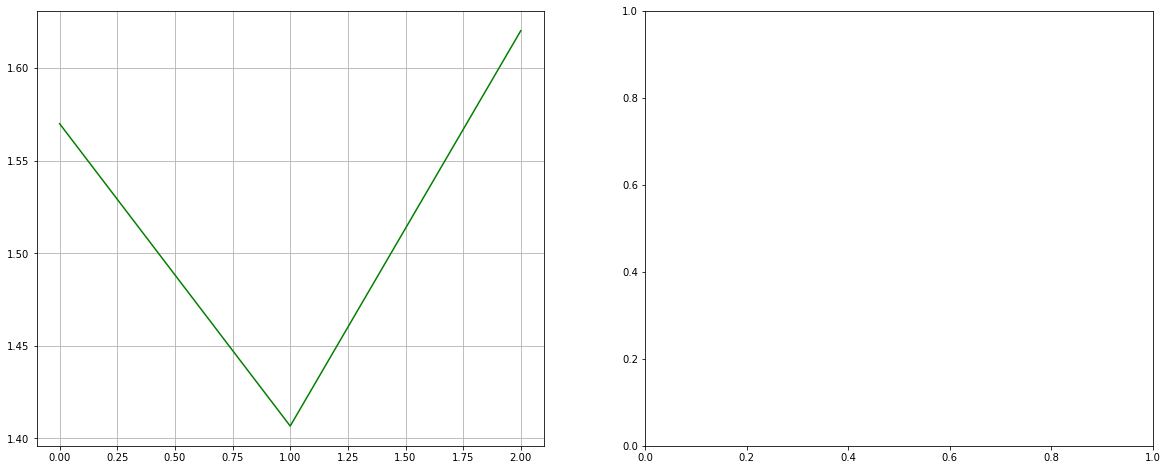

In [35]:
try:
    process(resnet50, train_data_loader, val_data_loader, NUM_EPOCHS, lr)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
333plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

# OVER SAMPLEING


In [20]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

In [28]:
import argparse
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='./data/oven', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet50')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [29]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [30]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes)) 
weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 500) 
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  

train_data_loader  = train_loader

# Under_Sample

In [52]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes)) 
weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 500) 
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 7962)                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  

train_data_loader  = train_loader

In [53]:
#weights = class_weight.compute_class_weight(
#    'balanced', np.unique(training_list), training_list)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

#criterion = nn.CrossEntropyLoss(class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.0001, momentum=0.9)

In [54]:
Oversample = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
Oversample.eval().to(device)

Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
# try:
#     model_trained = train_model(Oversample, train_data_loader, criterion, optimizer, train_loss, train_acc, total_step, NUM_EPOCHS)
# except Exception:
#     print(traceback.format_exc())
#     print(torch.cuda.memory_summary(device=None, abbreviated=False))

try different model

In [39]:
train_loader = train_data_loader
test_loader = val_data_loader

Dataset: 39810     training samples & 7962     testing samples

Distribution of classes in dataset:


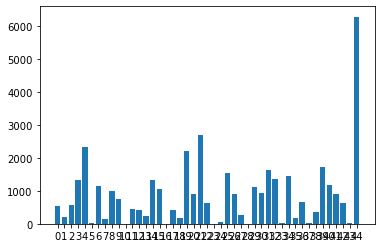

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
        
#!pip install seaborn
import seaborn as sns

print('Dataset:   %d  training samples & %d  testing samples\n' % (
   len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [ ]:
# import torch

# tensor1 = torch.tensor([1.0,2.0],requires_grad=True)

# print(tensor1)
# print(type(tensor1))

# tensor1 = tensor1.detach().numpy()

# print(tensor1)
# print(type(tensor1))

In [50]:
valid_loss_min = np.Inf
y_true = []
y_pred = [] 
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)
num_epochs =3
actuals, probabilities = [], []

#def adjust_learning_rate(optimizer, epoch):
#    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
#    lr = args.lr * (0.1 ** (epoch // 30))
#    for param_group in optimizer.param_groups:
#        param_group['lr'] = lr

def process_Oversample(model, train_loader, test_loader):
#   model = resnet50
    model = torch.nn.DataParallel(model).cuda()

#    model = torchvision.models.__dict__[args.arch]()
#    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
#        model.features = torch.nn.DataParallel(model.features)
#        model.cuda()
#    else:
#        model = torch.nn.DataParallel(model).cuda()

    # define loss function (criterion) and optimizer
    criterion = torch.nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    # train & test process
    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            running_loss = 0.0
            optimizer.zero_grad()
            output = model(data)
            outputs = output
            loss = criterion(output, target)
            # Backpropagation.
            loss.backward()
            optimizer.step()         
######## Simon's function
            correct = 0
            total=0
            running_loss += loss.item()
            _,pred = torch.max(output, dim=1)
#           actuals.extend(target.view_as(pred).cpu() == 45)
#           probabilities.extend(np.exp(output.cpu()[:, 44]))
            correct += torch.sum(pred==target).item()
            total += target.size(0)
#           outputs_binary_list = get_outputs_binary_list(
#               outputs.clone().detach().cpu()
#            )
            #print("matrix predict {} target {}".format(pred, target_))
            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, num_epochs, batch_idx * batch_size, total_step, loss.item()))
           # y_true.extend(target.detach().cpu().numpy())
           #y_pred.extend(outputs_binary_list)
            train_acc.append(100 * correct / total)
            train_loss.append(running_loss/total_step)
            print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
                
 ##########            
                             
            print('\rTraining       %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)
        
        
        # F1 score    
         #f1_score =calculate_f1_score (y_true, y_pred, average='micro')
         #return epoch_loss, epoch_acc, f1_score    
            #running_loss += loss.item() * inputs.size(0)
            #running_corrects += torch.sum(preds == labels.data)
            # Add these lines to obtain f1_score  
            from sklearn.metrics import f1_score   
            #f1_score = f1_score(labels.data, preds)
        #or: f1_score = f1_score(labels.cpu().data, preds.cpu())   
            

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
 #       displayROC_Curve(actuals, probabilities)

        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], [] 
    
#    for epoch in range(1, args.epochs + 1):
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        correct = 0
        total=0
#       adjust_learning_rate(optimizer, epoch)
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        fig = plt.figure(figsize=(20,10))
        plt.title("Train-Validation Accuracy")
        plt.plot(train_acc, label='train')
        plt.plot(val_acc, label='validation')
        plt.xlabel('num_epochs', fontsize=12)
        plt.ylabel('accuracy', fontsize=12)
        plt.legend(loc='best')
    vis(test_accs, confusion_mtxes, classe_labels)

# Run Oversample Model

Epoch [1/3], Step [0/31848], Loss: 13.4773

train-loss: 0.0001, train-acc: 0.0000
Training       1/32
train-loss: 0.0001, train-acc: 0.3906
Training       2/32
train-loss: 0.0001, train-acc: 0.0000
Training       3/32
train-loss: 0.0001, train-acc: 0.3906
Training       4/32
train-loss: 0.0001, train-acc: 2.3438
Training       5/32
train-loss: 0.0001, train-acc: 3.1250
Training       6/32
train-loss: 0.0001, train-acc: 3.1250
Training       7/32
train-loss: 0.0001, train-acc: 5.0781
Training       8/32
train-loss: 0.0001, train-acc: 7.4219
Training       9/32
train-loss: 0.0001, train-acc: 8.5938
Training       10/32
train-loss: 0.0001, train-acc: 6.2500
Training       11/32
train-loss: 0.0001, train-acc: 9.7656
Training       12/32
train-loss: 0.0001, train-acc: 9.7656
Training       13/32
train-loss: 0.0001, train-acc: 8.5938
Training       14/32
train-loss: 0.0001, train-acc: 10.5469
Training       15/32
train-loss: 0.0001, train-acc: 9.3750
Training       16/32
train-loss: 0.0001, 

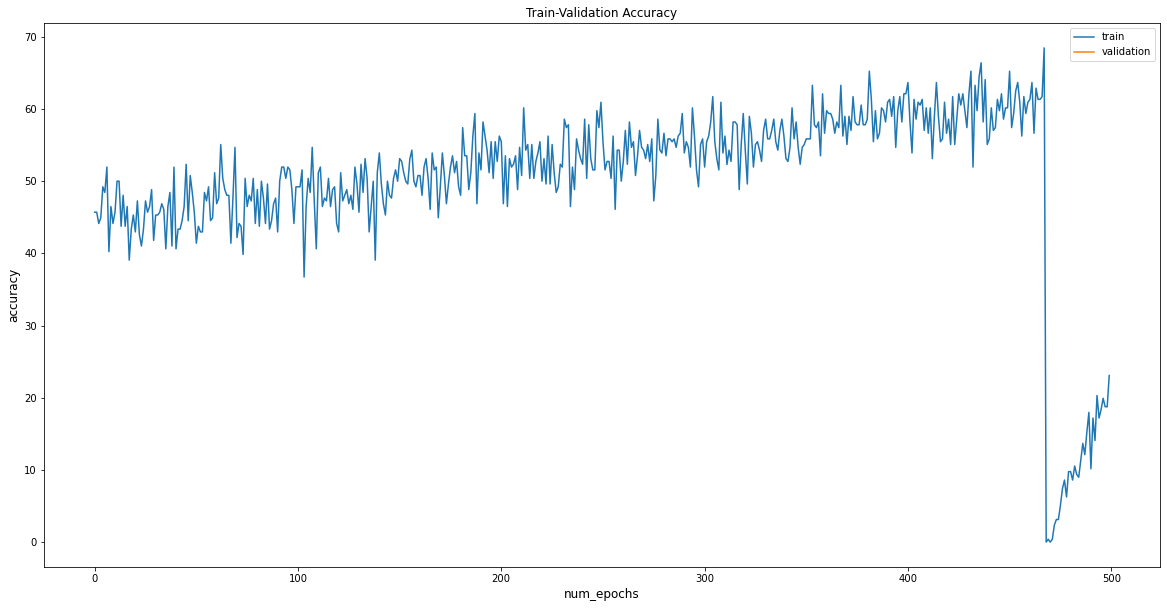

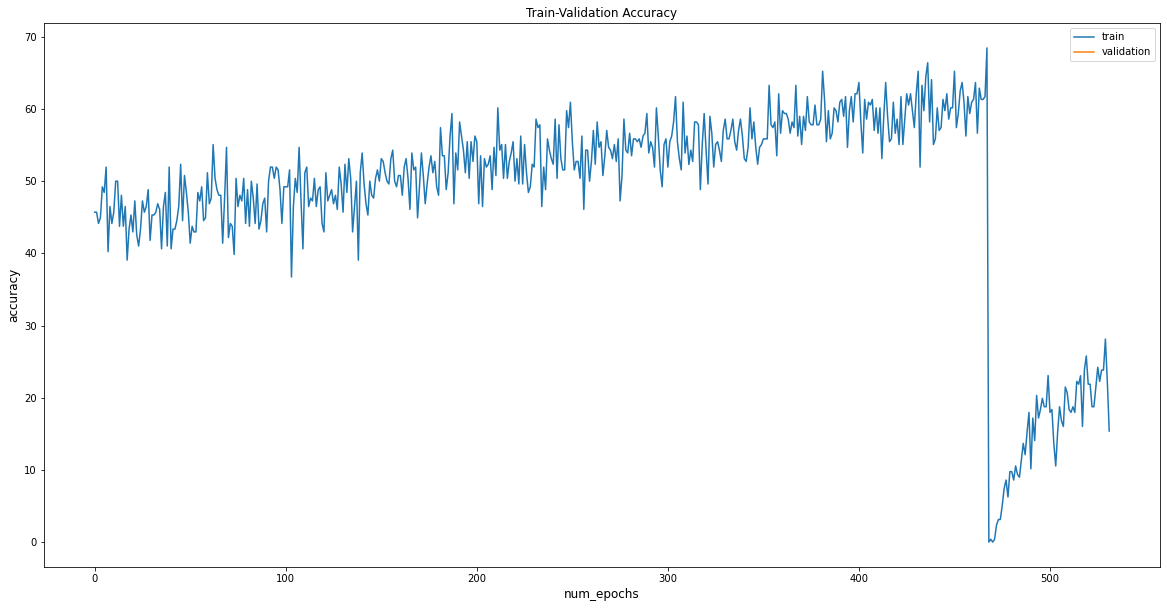

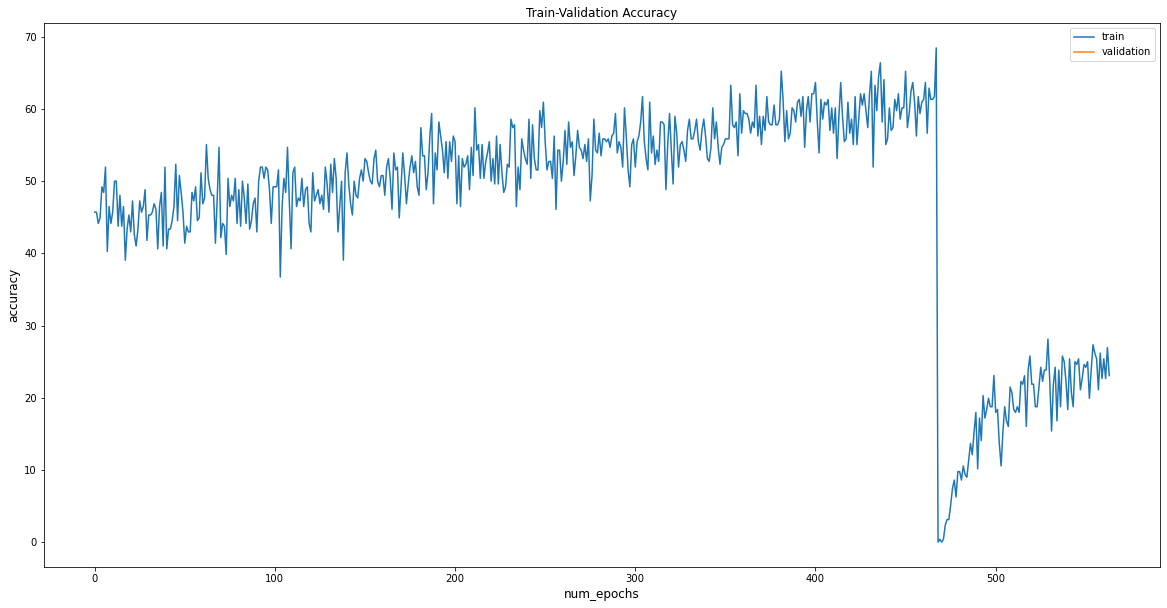

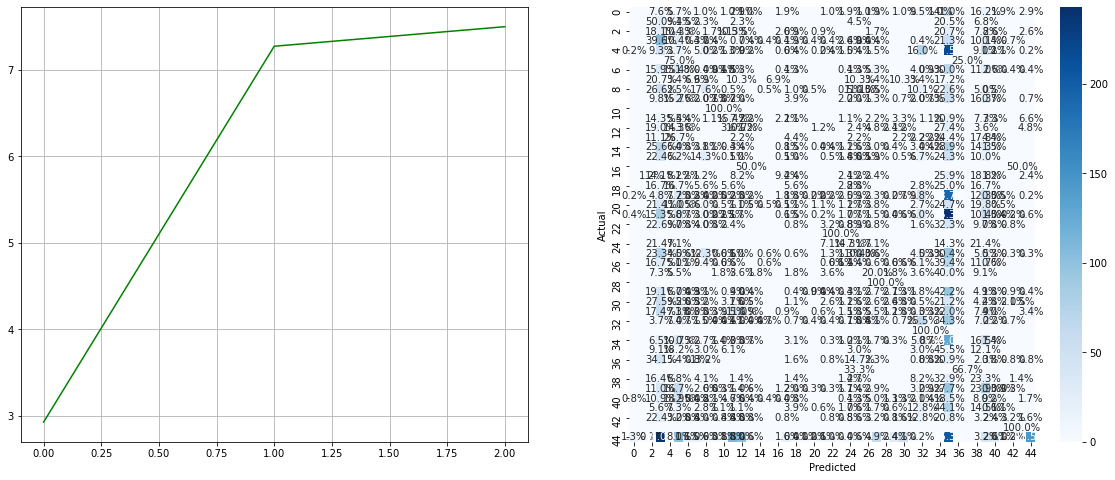

NoneType: None

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2209 MB |    4096 MB |   13364 GB |   13362 GB |
|       from large pool |    2086 MB |    3955 MB |   13190 GB |   13188 GB |
|       from small pool |     123 MB |     172 MB |     174 GB |     174 GB |
|---------------------------------------------------------------------------|
| Active memory         |    2209 MB |    4096 MB |   13364 GB |   13362 GB |
|       from large pool |    2086 MB |    3955 M

In [55]:
process_Oversample (Oversample, train_loader, test_loader)
print(traceback.format_exc())
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
# fig = plt.figure(figsize=(20,10))
# plt.title("Train-Validation Accuracy")
# plt.plot(train_acc, label='train')
# plt.plot(val_acc, label='validation')
# plt.xlabel('num_epochs', fontsize=12)
# plt.ylabel('accuracy', fontsize=12)
# plt.legend(loc='best')

In [56]:
print(traceback.format_exc())
print(torch.cuda.memory_summary(device=None, abbreviated=False))

NoneType: None

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2209 MB |    4096 MB |   13364 GB |   13362 GB |
|       from large pool |    2086 MB |    3955 MB |   13190 GB |   13188 GB |
|       from small pool |     123 MB |     172 MB |     174 GB |     174 GB |
|---------------------------------------------------------------------------|
| Active memory         |    2209 MB |    4096 MB |   13364 GB |   13362 GB |
|       from large pool |    2086 MB |    3955 M